# DEEP LEARNING MINI PROJECT 1

* Name: Disha Lamba

  netid: dl4747

* Name: Evan Lehrer

  netid: el3294
* Name: Junda Wu

  netid: jw6466



## Importing libraries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
from prettytable import PrettyTable
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import json
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params += params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

## ResNet Architecture:

Our study focuses on model re-scaling of the vanilla ResNet-18  model. The predefined hyperparameter sets, which are changeable in our problem setting, are related to the design of the ResNet model including model depth, model width and kernel sizes. 

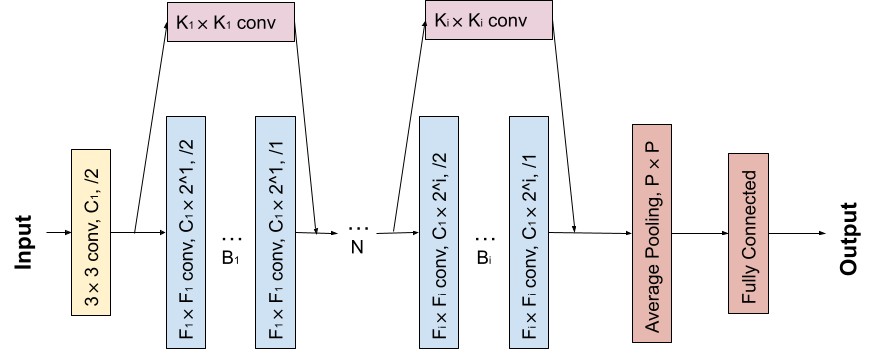

 In our model architecture design, $C_1$ is the essential hyperparameter to control the width of the ResNet model. $N$ and $\{B_i\}_{i=1}^N$ are jointly deciding the model depth, but in a different way. By generally increasing $\{B_i\}_{i=1}^N$, each residual layer is deeper, which makes the skip connection relatively less frequent. $N$ is limited to less than $6$ in our design, since the input resolution and the stride step are fixed. In addition to model width and depth, kernel sizes in the residual layer $\{F_i\}_{i=1}^N$ and the kernel sizes of the skip connection layer $\{K_i\}_{i=1}^N$ determinate the perceptive field of the convolutional networks. Finally, the average pooling size $P$ controls the complexity of the final feed-foward layer. Basically, the purpose of controlling $P$ is to find out how much details from the final feature map should be preserved. Our implementation

In [ ]:
# N:    residual layer (default: 4)
# B_i:  residual block in layer i (default: 2)
# C_1:  channel in layer 1 (default: 64)
# F_i:  filter in residual conv (default: 3)
# K_i:  filter in connection conv (default: 1)
# P:    average pooling size (default: 1)


class DropBlock2D(nn.Module):
    r"""Randomly zeroes 2D spatial blocks of the input tensor.
    As described in the paper
    `DropBlock: A regularization method for convolutional networks`_ ,
    dropping whole blocks of feature map allows to remove semantic
    information as compared to regular dropout.
    Args:
        drop_prob (float): probability of an element to be dropped.
        block_size (int): size of the block to drop
    Shape:
        - Input: `(N, C, H, W)`
        - Output: `(N, C, H, W)`
    .. _DropBlock: A regularization method for convolutional networks:
       https://arxiv.org/abs/1810.12890
    """

    def __init__(self, drop_prob, block_size):
        super(DropBlock2D, self).__init__()

        self.drop_prob = drop_prob
        self.block_size = block_size

    def forward(self, x):
        # shape: (bsize, channels, height, width)

        assert x.dim() == 4, \
            "Expected input with 4 dimensions (bsize, channels, height, width)"

        if not self.training or self.drop_prob == 0.:
            return x
        else:
            # get gamma value
            gamma = self._compute_gamma(x)

            # sample mask
            mask = (torch.rand(x.shape[0], *x.shape[2:]) < gamma).float()

            # place mask on input device
            mask = mask.to(x.device)

            # compute block mask
            block_mask = self._compute_block_mask(mask)

            # apply block mask
            out = x * block_mask[:, None, :, :]

            # scale output
            out = out * block_mask.numel() / block_mask.sum()

            return out

    def _compute_block_mask(self, mask):
        block_mask = F.max_pool2d(input=mask[:, None, :, :],
                                  kernel_size=(self.block_size, self.block_size),
                                  stride=(1, 1),
                                  padding=self.block_size // 2)

        if self.block_size % 2 == 0:
            block_mask = block_mask[:, :, :-1, :-1]

        block_mask = 1 - block_mask.squeeze(1)

        return block_mask

    def _compute_gamma(self, x):
        return self.drop_prob / (self.block_size ** 2)


def convNxN(
        C_in,
        C_out,
        F,
        stride=1,
        groups=1,
        dilation=1,
        padding=1
) -> nn.Conv2d:
    """NxN convolution with padding"""
    return nn.Conv2d(C_in, C_out, kernel_size=F, stride=stride,
                     padding=padding, groups=groups, bias=False, dilation=dilation)


class ResBlock(nn.Module):
    def __init__(
            self,
            C_in,
            C_out,
            F,
            stride=1,
            groups=1,
            dilation=1,
            base_width=64,
            downsample=None,
            norm_layer=nn.BatchNorm2d
    ) -> None:
        super(ResBlock, self).__init__()
        if groups != 1:
            raise ValueError('BasicBlock only supports groups=1')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = convNxN(C_in=C_in, C_out=C_out, F=F, stride=stride, padding=(F - 1) // 2)
        self.bn1 = norm_layer(C_out)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = convNxN(C_in=C_out, C_out=C_out, F=F, stride=1, padding=(F - 1) // 2)
        self.bn2 = norm_layer(C_out)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class ResNet(nn.Module):
    def __init__(
            self,
            C_1,
            N=4,
            F=[3, 3, 3, 3],
            B=[2, 2, 2, 2],
            K=[1, 1, 1, 1],
            P=1,
            num_classes=10,
            groups=1,
            width_per_group=64,
            norm_layer=nn.BatchNorm2d,
            D_P=0.,
            D_S=0,
            D_F=0.
    ) -> None:
        super(ResNet, self).__init__()
        self._norm_layer = norm_layer
        self.inplanes = C_1
        self.dilation = 1
        self.groups = groups
        self.base_width = width_per_group
        # Input Layer
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=F[0], stride=2, padding=(F[0] - 1) // 2, bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)

        self.layer1 = self._make_layer(self.inplanes, self.inplanes,
                                       K[0], F[0], B[0], dropout_prob=D_P, dropout_size=D_S)
        layer2 = []
        for i in range(N - 1):
            layer2.append(self._make_layer(self.inplanes * (2 ** i),
                                           self.inplanes * (2 ** (i + 1)),
                                           K[i], F[i], B[i], stride=2,
                                           dropout_prob=D_P, dropout_size=D_S))
        self.layer2 = nn.Sequential(*layer2)
        self.avgpool = nn.AdaptiveAvgPool2d((P, P))
        final_input = int(self.inplanes * (2 ** (N - 1)) * (P ** 2))
        if D_F > 0.:
            self.fc = nn.Sequential(
                nn.Dropout(D_F),
                nn.Linear(final_input, num_classes),
            )
        else:
            self.fc = nn.Linear(final_input, num_classes)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def _make_layer(self, inplanes, planes, K, F, blocks, dropout_prob=0, dropout_size=0, stride=1):
        if inplanes == planes:
            downsample = None
        else:
            downsample = nn.Sequential(
                nn.Conv2d(inplanes, planes, kernel_size=K, stride=stride, padding=(K - 1) // 2, bias=False),
                nn.BatchNorm2d(planes),
            )

        layers = []
        layers.append(ResBlock(inplanes, planes, F, stride, downsample=downsample))
        for _ in range(1, blocks):
            layers.append(ResBlock(planes, planes, F, downsample=None))
        if dropout_prob > 0:
            layers.append(DropBlock2D(dropout_prob, dropout_size))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        for layer in self.layer2:
            x = layer(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        self.rep = x
        x = self.fc(x)

        return x

## Upscaling the model using compound scaling

The Efficientnet paper sets out the baseline for various methods to scale a model in order to get better accuracy. The 3 ways to scale a model are: 
* Resolution
* Depth
* Width

To start with, we first performed a grid search for all possible combinations of hyper-parameters, which gave us a total of 136 results. To ease our experimentation, we defined a number for each accuracy range.

In [ ]:
import pandas as pd
import seaborn as sns

data = pd.read_csv("new-results.csv")
data = data.drop('Unnamed: 0', 1)
for key in ['B', 'F', 'K']:
    items = data[key].tolist()
    items = [str(i[1]) for i in items]
    data[key] = items

# score range:
# 0 for <80
# 1 for 80 - 85
# 2 for 85 - 90
# 3 for >90

data['score'] = np.where(
   (data['score'] >= 0.70) & (data['score'] < 0.80) , 0, data['score']
   )

data['score'] = np.where(
   (data['score'] >= 0.8) & (data['score'] < 0.85) , 1, data['score']
   )

data['score'] = np.where(
   (data['score'] >= 0.85) & (data['score'] < 0.90) , 2, data['score']
   )

data['score'] = np.where(
   (data['score'] >= 0.9) & (data['score'] < 0.95) , 3, data['score']
   )

print(data.head(10))


   N  C_1  P  B  F  K  score  epoch
0  1  128  1  2  3  1    2.0     48
1  3   32  1  1  3  1    2.0     48
2  3   64  2  3  3  1    2.0     45
3  4   16  1  2  3  1    1.0     48
4  2   64  1  3  5  1    2.0     46
5  2   64  1  2  7  5    2.0     48
6  2   64  1  1  5  3    2.0     48
7  3   16  1  3  3  1    1.0     48
8  2  128  2  3  3  3    3.0     42
9  5   16  2  1  3  1    0.0     47


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """


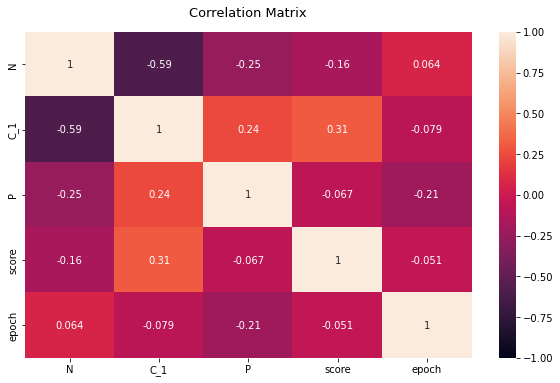

In [ ]:
data.corr()
plt.figure(figsize=(10, 6))
heatmap = sns.heatmap(data.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Matrix', fontdict={'fontsize':13}, pad=15);

We observe that there is a strong negative correlation between N and $C_1$ i.e if the number of residual layers increase then the number of channels in residual layers decrease and vice versa. Now that we know N and $C_1$ are strongly correlated, we start our compound scaling by fixing N and $C_1$ in our first step. We start by compound scaling on P(average pool kernel size) and B(number of residual blocks in a residual layer) with respect to N and $C_1$.

### Step 1:
First, we will perform compound scaling on P(average pool kernel size) and B(number of residual blocks in a residual layer) with respect to N and C_1.

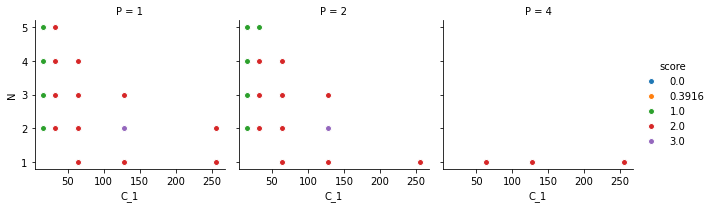

In [ ]:
graph = sns.FacetGrid(data, col ="P",  hue ="score")
# map the above form facetgrid with some attributes
graph.map(plt.scatter, "C_1", "N", edgecolor ="w").add_legend()
# show the object
plt.show()

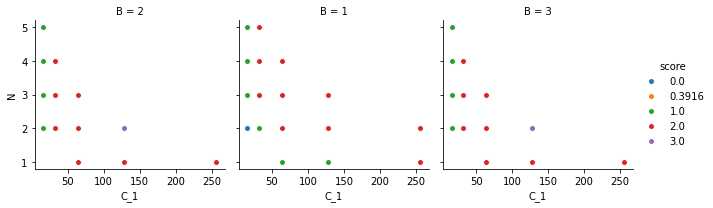

In [ ]:
graph = sns.FacetGrid(data, col ="B",  hue ="score")
# map the above form facetgrid with some attributes
graph.map(plt.scatter, "C_1", "N", edgecolor ="w").add_legend()
# show the object
plt.show()

From both these plots, we observe that to achieve a score of 3 we can set our hyper-parameters values as N = 2, C_1 = 128, P = 1 or 2 and B = [2,2] or [3,3]. 

### Step 2:
Now that we have identified our optimal values of N, $C_1$, P and B. We move to our second step by fixing N, C_1, P and B and find best values for F(convolution kernel size in a Residual Layer) and K(Skip connection kernel size in a Residual Layer).


In [ ]:
#filter dataframe
c1 = data.loc[(data['N']==2) & (data['C_1']== 128) & (data['score'] == 3)]
print(c1)

     N  C_1  P  B  F  K  score  epoch
8    2  128  2  3  3  3    3.0     42
13   2  128  1  3  3  3    3.0     49
36   2  128  2  3  3  5    3.0     48
51   2  128  1  3  3  1    3.0     48
58   2  128  2  2  3  1    3.0     47
61   2  128  2  3  3  1    3.0     47
112  2  128  1  2  3  1    3.0     48
126  2  128  1  3  3  5    3.0     46


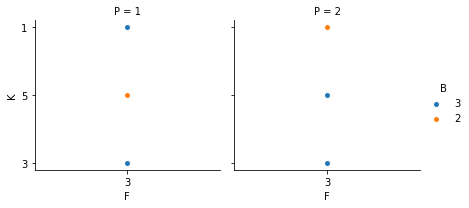

In [ ]:
graph = sns.FacetGrid(c1, col ="P",  hue ="B")
# map the above form facetgrid with some attributes
graph.map(plt.scatter, "F", "K", edgecolor ="w").add_legend()
# show the object
plt.show()

All 3 plots, show us that to achieve a score of 3 we can set our hyper-parameters values as N = 2, $C_1$ = 128, P = 1 or 2 B = [2,2], [3,3], F = [3,3], K = [1,1] or [3,3] or [5,5]. 



After replacing the score range to its original accuracy value, we found out that we can achieve an accuracy of 90.70\% if we have our hyper-parameter values  
From the above plots, we get our hyperparameters as

N = 2

C_1 = 128

P = 1

B = [3, 3]

F = [3, 3]

K = [3, 3]

## Visualizations

In [ ]:
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

hp = {
        'N': 2,
        'C_1': 128,
        'P': 1,
        'B': [3, 3],
        'F': [3, 3],
        'K': [3, 3]
    }
net = ResNet(**hp)
net = net.cuda()
#downloading our model as per our hyperparameters
net.load_state_dict(torch.load("{_N__ 2, _C_1__ 128, _P__ 1, _B__ [3, 3], _F__ [3, 3], _K__ [3, 3], _D_P__ 0.0, _D_S__ 0, _D_F__ 0.0}.pt"))

normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [ ]:
training_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,
        ]), download=True),
        batch_size=256, shuffle=True,
        num_workers=0, pin_memory=True)

validation_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=128, shuffle=False,
        num_workers=0, pin_memory=True)


total = {c: 0 for c in classes}
correct = {c: 0 for c in classes}
with torch.no_grad():
    for test_data in validation_loader:
        inputs, labels = test_data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        for i, c in enumerate(classes):
            total[c] += (labels == i).sum().item()
            correct[c] += (predicted[labels == i] == labels[labels == i]).sum().item()


In [ ]:
print({c: correct[c]/total[c] for c in classes})

{'plane': 0.905, 'car': 0.969, 'bird': 0.848, 'cat': 0.743, 'deer': 0.899, 'dog': 0.866, 'frog': 0.949, 'horse': 0.93, 'ship': 0.944, 'truck': 0.923}


## Ground Truth

               cat                cat                cat                cat                dog


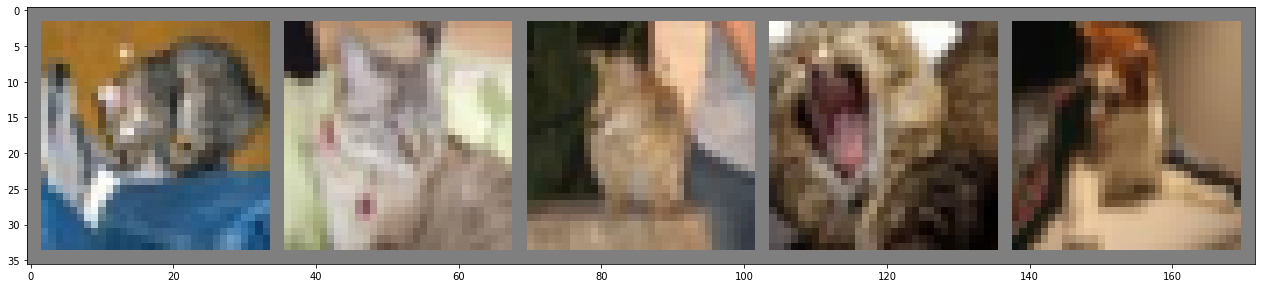

In [ ]:
# get some random training images
dataiter = iter(validation_loader)
images, labels = dataiter.next()
plt.figure(figsize=(22,10)) 

outputs = net(images.cuda())
_, predicted = torch.max(outputs.data, 1)

# show images
# cat class
imshow(torchvision.utils.make_grid(images[labels==3][0:5,:,:]))
# print labels
# print(' '.join('%18s' % classes[labels[labels==3][j]] for j in range(5)))
print(' '.join('%18s' % classes[predicted[labels==3][j].item()] for j in range(5)))

              deer               deer               ship               deer               deer


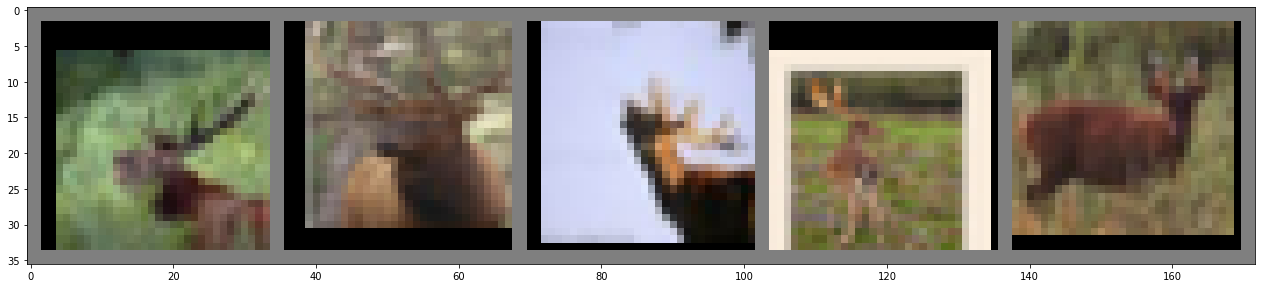

In [ ]:
# get some random training images
dataiter = iter(training_loader)
images, labels = dataiter.next()
plt.figure(figsize=(22,10)) 

outputs = net(images.cuda())
_, predicted = torch.max(outputs.data, 1)

# show images
#deer class
imshow(torchvision.utils.make_grid(images[labels==4][0:5,:,:]))
# print labels
# print(' '.join('%18s' % classes[labels[labels==3][j]] for j in range(5)))
print(' '.join('%18s' % classes[predicted[labels==4][j].item()] for j in range(5)))

If your observe carefully through all the samples, you will observe that some samples can't be visually labelled as cat or a deer(in the above 2 examples). These samples are visually similar to the cat or deer class in terms of color or shape but these samples can't be exactly classified as cat or deer.

## Cluster Analysis

To better understand our proposed method, we visualized the feature embedding of the unlabeled samples on CIFAR-10 using t-SNE. 

In [ ]:
validation_loader = torch.utils.data.DataLoader(
        datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            normalize,
        ])),
        batch_size=100, shuffle=False,
        num_workers=0, pin_memory=True)

reps = []
label = []
with torch.no_grad():
    for i, test_data in enumerate(validation_loader):
        if i == 20:
            break
        inputs, labels = test_data
        inputs = inputs.cuda()
        labels = labels.cuda()
        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        reps.append(net.rep.data.detach().cpu().clone())
        label.extend(labels.tolist())
reps = torch.cat(reps, dim=0).numpy()
label = np.asarray(label)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.001s...
[t-SNE] Computed neighbors for 2000 samples in 0.120s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 2.028058
[t-SNE] KL divergence after 250 iterations with early exaggeration: 69.493225
[t-SNE] KL divergence after 1000 iterations: 1.166057


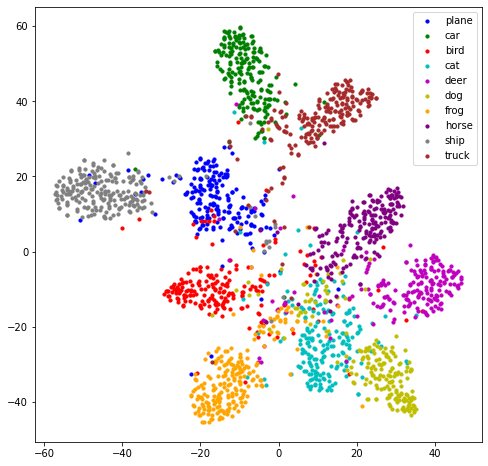

In [ ]:
import matplotlib.pyplot as plt
import matplotlib
from sklearn.manifold import TSNE

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'orange', 'purple', 'grey', 'brown']
plt.figure(figsize=(8, 8))
tsne = TSNE(n_components=2, verbose=1, random_state=42, n_jobs=8)
original = tsne.fit_transform(reps)
for i in range(10):
    plt.scatter(original[label == i, 0], original[label == i, 1], c=colors[i], s=10, label=classes[i])
plt.legend()

We observe that although each label is largely their own distinct cluster, several animal labels are clustered together (in terms of cosine distance); with some areas bordering each other. This indicates that our model had difficulty finding meaningful distinctions for some animal images;  there was a constraint of enforcing neighbors to be close. Although further review would be pertinent to diagnose the exact reason, a qualitative review would suggest that the samples may be visually similar in terms of color and number of legs (cat, dog, deer, horse)